In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [2]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [3]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [4]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [5]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [72]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    return Redshift_success_rate,Good_data_completeness
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [7]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [8]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [9]:
SV_depth_catalog = pf.getdata(dir+dataname,1)

SV_depth_catalog['SPECTYPE']

NameError: name 'dataname' is not defined

In [182]:
#dataname = 'ELG_80610_Cascades_subsamples_v2.fits'
dataname ='ELG_80606_80608_80610_OII.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.503) & (SV_depth_catalog['Z']<1.575) & (SV_depth_catalog['subset_id']==1)]

#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.497) & (SV_depth_catalog['zwarn_cas']==0)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['zwarn_cas']==0))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.4))]# & (SV_depth_catalog['zwarn_cas']==0))]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]

SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
print('slope')
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>40)]# & (SV_depth_catalog['Z']<1.65)]
print('DELTACHI2_cas>28')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>100)]# & (SV_depth_catalog['Z']<1.62)]
print('DELTACHI2_cas>100')# & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.54421768707483
Good data completeness: 1.0
Combined value: 0.54421768707483
--------
DELTACHI2_cas>20
Redshift success rate: 0.8259109311740891
Good data completeness: 0.85
Combined value: 0.7020242914979757
--------
slope
Redshift success rate: 0.9041666666666667
Good data completeness: 0.9041666666666667
Combined value: 0.8175173611111112
--------
DELTACHI2_cas>28
Redshift success rate: 0.8651685393258427
Good data completeness: 0.6416666666666667
Combined value: 0.5551498127340825
--------
DELTACHI2_cas>100
Redshift success rate: 0.9285714285714286
Good data completeness: 0.325
Combined value: 0.3017857142857143


(0.9285714285714286, 0.325)

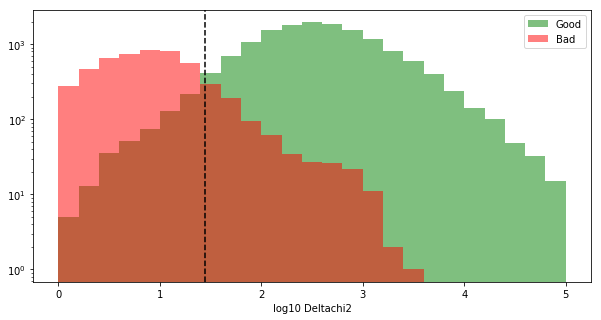

In [143]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=20,color='b',alpha=0.3)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')
#plt.hist(np.log10(bad_2['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='b',label='Bad_1')

plt.axvline(np.log10(28),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

Text(0, 0.5, 'log10 DELTACHI2')

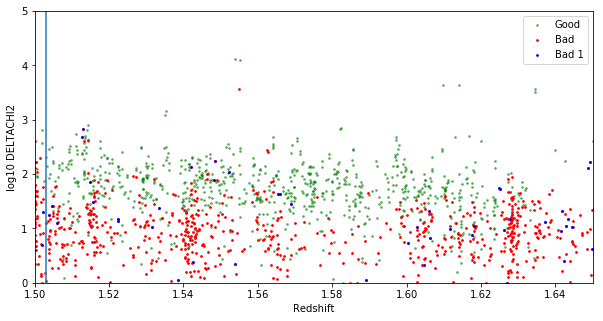

In [144]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')

plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

plt.legend()
plt.xlim(1.5,1.65)
plt.axvline(1.497)
plt.axvline(1.503)
plt.ylim(0,5)
#plt.axhline(np.log10(30))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

Text(0.5, 1.0, 'ELG 80606 & 80608 & 80610')

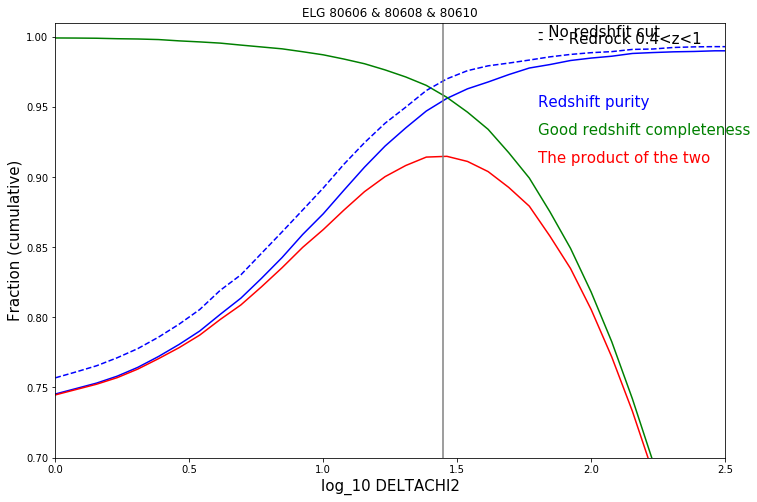

In [154]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0.0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.7,1.01)
plt.xlim(0.0,2.5)
#plt.axhline(0.98,ls='--')

SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.0) & (SV_depth_catalog['Z']>0.4)]

bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--')
plt.plot(bins,good_fraction,color='g',ls='--')
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--')

plt.text(1.8,1.0,'- No redshfit cut',fontsize=15,color='black')
plt.text(1.8,0.995,'- - - Redrock 0.4<z<1',fontsize=15,color='black')
plt.text(1.8,0.95,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.93,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.91,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(28),color='grey')
plt.ylabel('Fraction (cumulative)',fontsize=15)
plt.title('ELG 80606 & 80608 & 80610')

In [14]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog
len(SV_depth_catalog[(SV_depth_catalog['best_quality']<2.5) & (SV_depth_catalog['subset_id']==1)])


765

Text(0.5, 0, 'FIBERID')

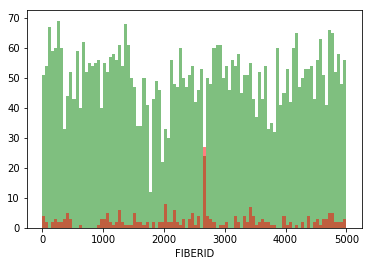

In [15]:
plt.hist(good_catalog['FIBER'][good_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='g')
plt.hist(bad_catalog['FIBER'][bad_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='r')
plt.xlabel('FIBERID')

5660
20630


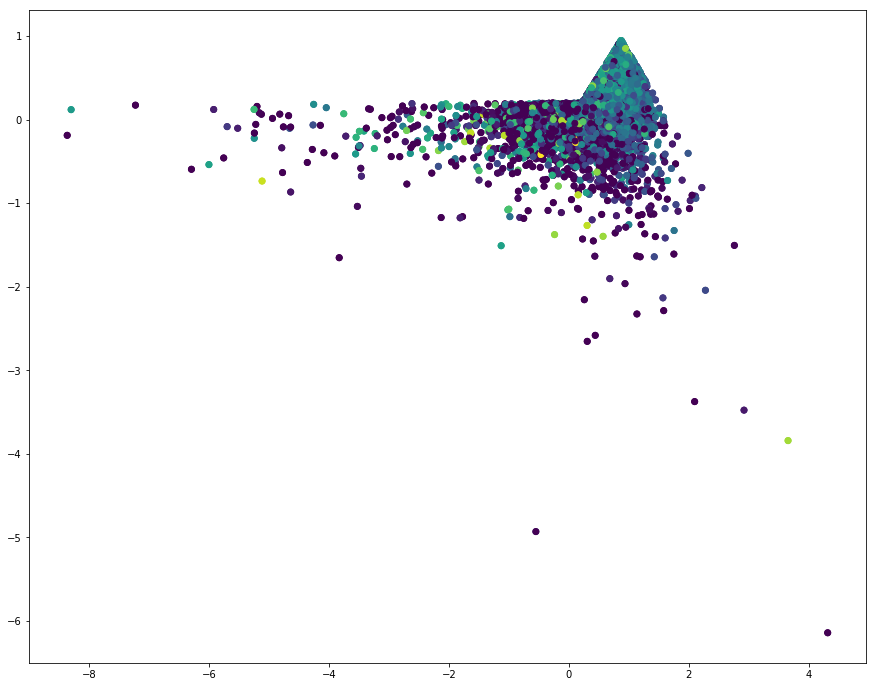

In [69]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog#[SV_depth_catalog['subset_id']==1]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
print(len(bad_catalog))
print(len(SV_depth_catalog))
plt.figure(figsize=(15,12))
plt.scatter(flux_to_mag(SV_depth_catalog)['rz'],flux_to_mag(SV_depth_catalog)['gr'],c=np.log10(SV_depth_catalog['DELTACHI2_cas']),vmin=1,vmax=5)
#plot_ELG_cc_plot(good_catalog)
#plot_ELG_cc_plot(bad_catalog)

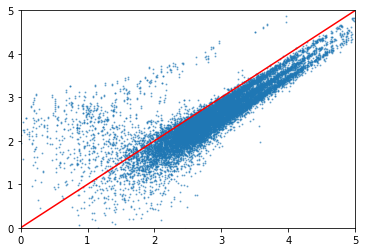

In [70]:
plt.scatter(np.log10(good_catalog['DELTACHI2']),np.log10(good_catalog['DELTACHI2_cas']),s=1,alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10),color='r')

In [71]:
SV_depth_catalog['zwarn'][np.where(np.log10(SV_depth_catalog['DELTACHI2_cas'])-np.log10(SV_depth_catalog['DELTACHI2'])>2)]

array([4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int16)

218
23


Text(0, 0.5, 'log10 DELTACHI2')

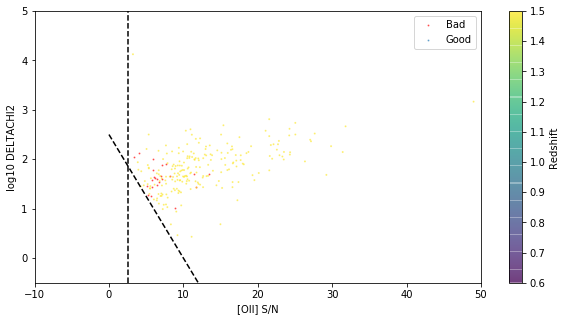

In [149]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.575) & (SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['subset_id']==1)]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]

good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
print(len(good_catalog))
print(len(bad_catalog))
plt.figure(figsize=(10,5))
plt.scatter(bad_catalog['FOII']/bad_catalog['FOII_ERR'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=1,alpha=0.5,label='Bad')

plt.scatter(good_catalog['FOII']/good_catalog['FOII_ERR'],np.log10(good_catalog['DELTACHI2_cas']),c=good_catalog['Z'],s=1,vmax=1.5,vmin=0.6,alpha=0.5,label='Good')
plt.colorbar(label='Redshift')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

plt.legend()
plt.xlim(-10,50)
plt.ylim(0,5)
x = np.arange(0,20)
y = -0.25*x+2.5
plt.plot(x,y,ls='--',color='black')
plt.axvline(2.5,ls='--',color='black')
plt.xlim(-10,50)
plt.ylim(-0.5,5)
plt.xlabel('[OII] S/N')
plt.ylabel('log10 DELTACHI2')

['unusually narrow CIV line Lyman alpha emitter' 'Sky lines' '' '' '' ''
 '' 'weak resolved doublet built from/on one strong skyline residual'
 'unphysical flux increase at Z-band end + no doublet + absorption at 7180AA (MgII ?)  looks robust rising flux at red end probably not real(?) but fit as Balmer break'
 'weak doublet built from/on skyline residuals' 'residuals in Z'
 'redrock missed clear doublet probably due to sky residuals' '' '' '' ''
 'noisy O II'
 'absorption and noise around O II and degeneracy between 2 best models'
 '' 'bad splicing and O II not conclusive' '' 'sky lines' '' '' '' ''
 'Broad [OII] on sky lines strong doublet plagged by noise spike on one line'
 'Sky lines weak doublet built from/on noise spikes' ''
 'doublet from/on skyline residuals is higly dubious Sky lines' '' ''
 'very likely LAE at z=2.292'
 'dubious resolved doublet over/from two strong skyline residuals On the edge around sky lines / could be real but not sure'
 '' 'bad B/R splicing'
 'weak res

(array([ 0.,  3., 18.,  0.,  2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

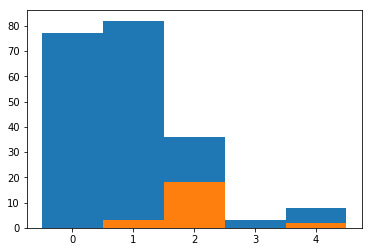

In [180]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.575) & (SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['subset_id']==1)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
plt.hist(bad_catalog['best_quality'],bins=5,range=(-0.5,4.5))
print(bad_catalog['all_VI_comments'])

SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
plt.hist(bad_catalog['best_quality'],bins=5,range=(-0.5,4.5))


%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
x = good_catalog['Z']
y = good_catalog['FOII']/good_catalog['FOII_ERR']
z = np.log10(good_catalog['DELTACHI2_cas'])

ax.scatter(x, y, z, c=good_catalog['Z'],s=1,alpha=0.5)


x = bad_catalog['Z']
y = bad_catalog['FOII']/bad_catalog['FOII_ERR']
z = np.log10(bad_catalog['DELTACHI2_cas'])

ax.scatter(x, y, z, c='r',s=1,alpha=0.5)

ax.set_xlabel('Redshift')
ax.set_ylabel('[OII] S/N')
ax.set_zlabel('log10 Deltachi2')

plt.show()

In [184]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['subset_id']==1) & (SV_depth_catalog['zwarn_cas']==0)]

In [185]:
def selection_fraction(all_catalog):
    redrock_z = all_catalog['Z']
    OII_SN = all_catalog['FOII']/all_catalog['FOII_ERR']
    log10_deltha2 = np.log10(all_catalog['DELTACHI2_cas'])
    FOII = all_catalog['FOII']
    search_low_z = np.where((redrock_z>0.6)& (redrock_z<1.0) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0))
    search_low_z_all = np.where((redrock_z>0.6)& (redrock_z<1.0))
    search_high_z = np.where(((redrock_z>1.0)& (redrock_z<1.497) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0)) | ((redrock_z>1.502)& (redrock_z<1.55) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0)))
    search_high_z_all = np.where(((redrock_z>1.0)& (redrock_z<1.497)) | ((redrock_z>1.502)& (redrock_z<1.55)))
    
    search_very_low_all = np.where(redrock_z<0.4)
    search_very_low = np.where((redrock_z<0.4) & (log10_deltha2>2))

    search_very_high_all = np.where((redrock_z>1.502) & (redrock_z<1.62))
    search_problem_all = np.where((redrock_z<1.502) & (redrock_z>1.497))
    print('Total N:',len(all_catalog))
    print('low z all:',len(search_low_z_all[0]))
    print('low z selection:',len(search_low_z[0]))
    print('high z all:',len(search_high_z_all[0]))
    print('high z selection:',len(search_high_z[0]))
    print('Very low z all:',len(search_very_low_all[0]))
    print('Very low z selection:',len(search_very_low[0])) 
    print('Very high z all:',len(search_very_high_all[0])) 
    print('Problem z all:',len(search_problem_all[0])) 

In [186]:
selection_fraction(SV_depth_catalog)

Total N: 8516
low z all: 3421
low z selection: 3161
high z all: 3149
high z selection: 2897
Very low z all: 1002
Very low z selection: 756
Very high z all: 470
Problem z all: 95


In [242]:
selection_fraction(SV_depth_catalog)

Total N: 8516
low z all: 3725
low z selection: 3281
high z all: 3149
high z selection: 2897
Very low z all: 1002
Very low z selection: 756
Very high z all: 545
Problem z all: 95


In [253]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.497) & (SV_depth_catalog['Z']<1.502)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)


In [254]:
print(len(SV_depth_catalog))
print(len(bad_catalog))
print(len(good_catalog))

233
216
17


In [255]:
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['Z']<1.3)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)

In [258]:
print(len(SV_depth_catalog_cut))
print(len(bad_catalog))
print(len(good_catalog))

104
88
16


In [111]:
#dataname = 'ELG_80610_Cascades_subsamples_v2.fits'
dataname ='ELG_80606_80608_80610_OII.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
redshift_bin = my_wise_ut.my_bin_maker(0.6,1.4,5)
redshift_bin['bin'][-1]=1.497
redshift_purity = []
good_data_completeness = []
for i_bin in range(0,len(redshift_bin['average_bin'])):
    SV_depth_catalog = pf.getdata(dir+dataname,1)
    SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>=redshift_bin['bin'][i_bin]) & (SV_depth_catalog['Z']<redshift_bin['bin'][i_bin+1])]

    print('--------')
    SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
    print('slope')
    out1,out2 = calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)
    redshift_purity.append(out1)
    good_data_completeness.append(out2)

--------
slope
Redshift success rate: 0.9982646420824295
Good data completeness: 0.9888268156424581
Combined value: 0.9871108471988269
--------
slope
Redshift success rate: 0.9975118188604131
Good data completeness: 0.9947890818858561
Combined value: 0.9923138664544408
--------
slope
Redshift success rate: 0.9935238095238095
Good data completeness: 0.9901290812452543
Combined value: 0.9837168167190945
--------
slope
Redshift success rate: 0.98043254376931
Good data completeness: 0.9892622099064773
Combined value: 0.9699048649134566


Text(0.7, 0.975, 'Good redshift completeness')

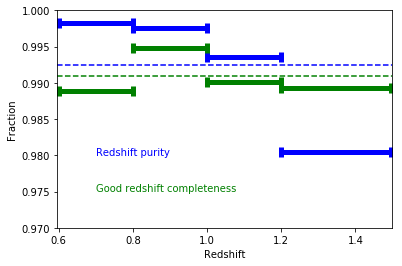

In [117]:
plt.errorbar(redshift_bin['average_bin'],redshift_purity,xerr=[redshift_bin['average_bin']-np.array(redshift_bin['bin'][0:-1]),
                                                              np.array(redshift_bin['bin'])[1:]-1*redshift_bin['average_bin']],ls='',capsize=5,lw=5,mew=5,color='b')




plt.errorbar(redshift_bin['average_bin'],good_data_completeness,xerr=[redshift_bin['average_bin']-np.array(redshift_bin['bin'][0:-1]),
                                                              np.array(redshift_bin['bin'])[1:]-1*redshift_bin['average_bin']],ls='',capsize=5,lw=5,mew=5,color='g')

plt.axhline(0.9925,color='b',ls='--')
plt.axhline(0.991,color='g',ls='--')
plt.ylim(0.97,1)
plt.xlim(0.595,1.4975)
plt.xlabel('Redshift')
plt.ylabel('Fraction')
plt.text(0.7,0.98,'Redshift purity',color='b')
plt.text(0.7,0.975,'Good redshift completeness',color='g')
